In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
with open('../datasets/monitor_labels.txt', 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line)

Energy Rating Data Dictionary for Computer Monitors (labelled) as at May 2015



Column - Description

Record ID - This is the unique registration ID record for the product and is taken from the GEMS product database

Status - This is the registration status of the product and must be either "Superseded" or "Approved"

Brand Name - This is the manufacturers brand

Model Number - This is the model number of the appliance, usually a unique field

Selling Countries - These are the countries where the product is registered for sale and may include Australia, New Zealand and/or Fiji

Manufacturing Countries - Country of manufacture

Screen Size - The diagonal measurement of the screen in cm

Screen Technology - Either LED (Light Emitting Diode) or LCD (Liquid Crystal Display)

Comparative Energy Consumption - This is the current Comparative Energy Consumption of the product which is it's nominal energy consumption expressed as kilowatt hours per years.

Active Standby Power - This is the am

In [3]:
data = pd.read_csv('../datasets/monitor.csv')
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 19 columns):
Record ID                         1583 non-null int64
Status                            1583 non-null object
Brand Name                        1583 non-null object
Model Number                      1583 non-null object
Family Name                       781 non-null object
Selling Countries                 1541 non-null object
Manufacturing Countries           1583 non-null object
Screen Size                       1583 non-null float64
Screen Technology                 1583 non-null object
Comparative Energy Consumption    1583 non-null float64
Active Standby Power              1583 non-null float64
Star Rating Index                 1583 non-null float64
Star Rating                       1583 non-null float64
Product Website                   579 non-null object
Representative Brand URL          657 non-null object
Availability Status               1583 non-null object
Expiry Date 

In [4]:
# Let us first find see the features which we might have to drop
print(data.columns.values)

# A relatively good dataset since the important features are non-empty, we can remove the irrelevant columns
print(data.isnull().sum(), '\n')

# Since these columns have more than 90% of the data of the same kind, we shall drop them
print(data['Availability Status'].value_counts())
print(data['Status'].value_counts())

# Even though most of the rows have details of LCD (LED) screens, it might be an important feature in our model
# Hence we shall retain Screen Technology
print(data['Screen Technology'].value_counts())

# Since we are also finding the star index of appliances which have passed their expiry date, we will remove that as well
columns = ['Record ID', 'Status', 'Availability Status','Model Number', 'Family Name', 'Selling Countries', 'Product Website', 'Representative Brand URL', 'Star Rating Index', 'Expiry Date', 'Star Image Large', 'Star Image Small']

# We can drop the columns
data.drop(columns, axis=1, inplace=True)
print(data.head(4), '\n')
print(data.info())

['Record ID' 'Status' 'Brand Name' 'Model Number' 'Family Name'
 'Selling Countries' 'Manufacturing Countries' 'Screen Size'
 'Screen Technology' 'Comparative Energy Consumption'
 'Active Standby Power' 'Star Rating Index' 'Star Rating'
 'Product Website' 'Representative Brand URL' 'Availability Status'
 'Expiry Date' 'Star Image Large' 'Star Image Small']
Record ID                            0
Status                               0
Brand Name                           0
Model Number                         0
Family Name                        802
Selling Countries                   42
Manufacturing Countries              0
Screen Size                          0
Screen Technology                    0
Comparative Energy Consumption       0
Active Standby Power                 0
Star Rating Index                    0
Star Rating                          0
Product Website                   1004
Representative Brand URL           926
Availability Status                  0
Expiry Date      

In [5]:
# Fill up missing value columns - But we have none!
missing_values_columns = [column for column in data.columns.values if data[column].isnull().sum()>0]
print(missing_values_columns)

# Since we have no missing values, we can also drop Brand and Country since we 
# will not need them
data.drop(['Brand Name', 'Manufacturing Countries'], axis=1, inplace=True)

[]


In [6]:
# We shall first do feature scaling on Screen Size and divide them into number classes
# print(data['Screen Size'].value_counts())
data['Screen Size'] = data['Screen Size'].astype(float)
screen_size_range = data['Screen Size'].max() - data['Screen Size'].min()
screen_size_mean = data['Screen Size'].mean()
for index, rows in data.iterrows():
    screen_size = (data.at[index, 'Screen Size'] - screen_size_mean)/screen_size_range

    if screen_size>-0.4 and screen_size<=-0.08: value = 0
    elif screen_size>-0.08 and screen_size<=-0.07: value = 1
    elif screen_size>-0.07 and screen_size<=-0.03: value = 2
    elif screen_size>-0.03 and screen_size<=-0.027: value = 3
    elif screen_size>-0.027 and screen_size<=-0.01: value = 4
    elif screen_size>-0.01 and screen_size<=0.044: value = 5
    elif screen_size>0.044 and screen_size<=0.045: value = 6
    elif screen_size>0.045 and screen_size<=0.2: value = 7
    elif screen_size>0.2 : value = 8
    data.at[index, 'Screen Size'] = value
    
data['Screen Size'] = data['Screen Size'].astype(int)
print(data['Screen Size'].value_counts())

3    235
6    234
1    207
2    180
0    178
4    161
7    153
5    139
8     96
Name: Screen Size, dtype: int64


In [7]:
# We will map Screen Technology to integer classes
data['Screen Technology'] = data['Screen Technology'].map({'LCD (LED)': 0, 'LCD': 1, 'OLED': 2}).astype(int)
data['Screen Technology'].value_counts()

0    1199
1     383
2       1
Name: Screen Technology, dtype: int64

In [8]:
# Seems like the data is present almost equally in buckets of size 10 in the range
print(data['Comparative Energy Consumption'].value_counts())
    
for index, row in data.iterrows():
    comp_energy = data.at[index, 'Comparative Energy Consumption']
    if comp_energy<=50: value = 0
    elif comp_energy>50 and comp_energy<=60: value = 1
    elif comp_energy>60 and comp_energy<=67: value = 2
    elif comp_energy>67 and comp_energy<=75: value = 3
    elif comp_energy>75 and comp_energy<=82: value = 4
    elif comp_energy>82 and comp_energy<=92: value = 5
    elif comp_energy>92 and comp_energy<=102: value = 6
    elif comp_energy>102 and comp_energy<=112: value = 7
    elif comp_energy>112 and comp_energy<=125: value = 8
    elif comp_energy>125 and comp_energy<=150: value = 9
    elif comp_energy>150 and comp_energy<=180: value = 10
    else: value = 11
    
    data.at[index, 'Comparative Energy Consumption'] = value

data['Comparative Energy Consumption'] = data['Comparative Energy Consumption'].astype(int)
print(data['Comparative Energy Consumption'].value_counts())

67.0     40
82.0     34
95.0     32
78.0     30
68.0     29
75.0     28
81.0     28
66.0     26
62.0     25
59.0     24
50.0     24
88.0     23
60.0     22
86.0     22
57.0     22
83.0     22
69.0     21
76.0     21
61.0     21
49.0     21
97.0     20
106.0    20
126.0    19
103.0    19
93.0     19
180.0    19
71.0     18
70.0     18
85.0     18
115.0    18
         ..
18.0      1
203.0     1
219.0     1
132.0     1
45.0      1
432.0     1
224.0     1
152.0     1
194.0     1
24.0      1
280.0     1
53.0      1
34.0      1
196.0     1
244.0     1
192.0     1
151.0     1
240.0     1
377.0     1
313.0     1
149.0     1
233.0     1
195.0     1
161.0     1
227.0     1
193.0     1
83.3      1
170.0     1
362.0     1
368.0     1
Name: Comparative Energy Consumption, Length: 195, dtype: int64
5     159
9     157
4     156
2     156
3     154
6     151
1     121
8     114
10    111
11    104
7     100
0     100
Name: Comparative Energy Consumption, dtype: int64


In [9]:
print(data['Star Rating'].value_counts())
for index, row in data.iterrows():
    star = data.at[index, 'Star Rating']
    if star<=4 : value = 0
    elif star>4 and star<6: value = 1
    else: value = 2
    data.at[index, 'Star Rating'] = value

data['Star Rating'] = data['Star Rating'].astype(int)
data['Star Rating'].value_counts()

4.5    292
6.0    256
4.0    227
5.5    219
5.0    211
3.5    124
7.0     68
2.5     66
3.0     60
1.5     29
2.0     24
1.0      5
8.0      1
9.0      1
Name: Star Rating, dtype: int64


1    722
0    535
2    326
Name: Star Rating, dtype: int64

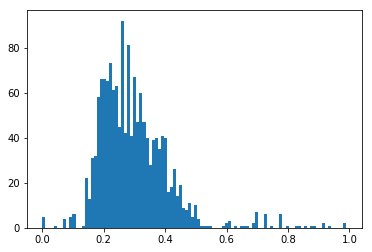

In [10]:
plt.hist(data.loc[data['Active Standby Power']<1, 'Active Standby Power'], bins=100)
plt.show()

In [11]:
# We see that the values are concentrated between 0.2 to 0.4 and so we shall divide them into buckets of 
# size 0.04 to 0.06 etc
print(data['Active Standby Power'].value_counts())
# print(data['Active Standby Power'].min(), data['Active Standby Power'].max())
for index, rows in data.iterrows():
    standby_power = data.at[index, 'Active Standby Power']
    
    if standby_power<=0.2: value = 0
    elif standby_power>0.2 and standby_power<=0.24: value = 1
    elif standby_power>0.24 and standby_power<=0.28: value = 2
    elif standby_power>0.28 and standby_power<=0.32: value = 3
    elif standby_power>0.32 and standby_power<=0.39: value = 4
    else: value = 5

    data.at[index, 'Active Standby Power'] = value

data['Active Standby Power'] = data['Active Standby Power'].astype(int)
print(data['Active Standby Power'].value_counts())

0.260000     86
0.280000     76
0.300000     65
0.220000     61
0.320000     57
0.200000     53
0.210000     51
0.190000     49
0.230000     49
0.310000     46
0.330000     45
0.250000     43
0.180000     43
0.240000     40
0.390000     39
0.290000     38
0.400000     38
0.370000     35
0.360000     34
0.270000     33
0.380000     31
0.340000     28
0.160000     27
0.430000     24
0.350000     19
0.420000     18
0.140000     16
0.410000     15
0.450000     15
0.170000     14
             ..
0.236000      1
0.313812      1
0.540000      1
0.830000      1
0.204000      1
0.650000      1
0.143000      1
0.324000      1
0.174000      1
47.380000     1
32.370000     1
0.225000      1
1.030000      1
0.264000      1
0.860000      1
0.940000      1
0.130000      1
0.214000      1
0.355000      1
0.398000      1
0.367800      1
0.279000      1
0.363000      1
0.153000      1
0.145000      1
0.630000      1
0.801000      1
0.338400      1
4.315200      1
0.520000      1
Name: Active Standby Pow

In [12]:
# We have sucessfully converted all the features into integer class
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 5 columns):
Screen Size                       1583 non-null int64
Screen Technology                 1583 non-null int64
Comparative Energy Consumption    1583 non-null int64
Active Standby Power              1583 non-null int64
Star Rating                       1583 non-null int64
dtypes: int64(5)
memory usage: 61.9 KB


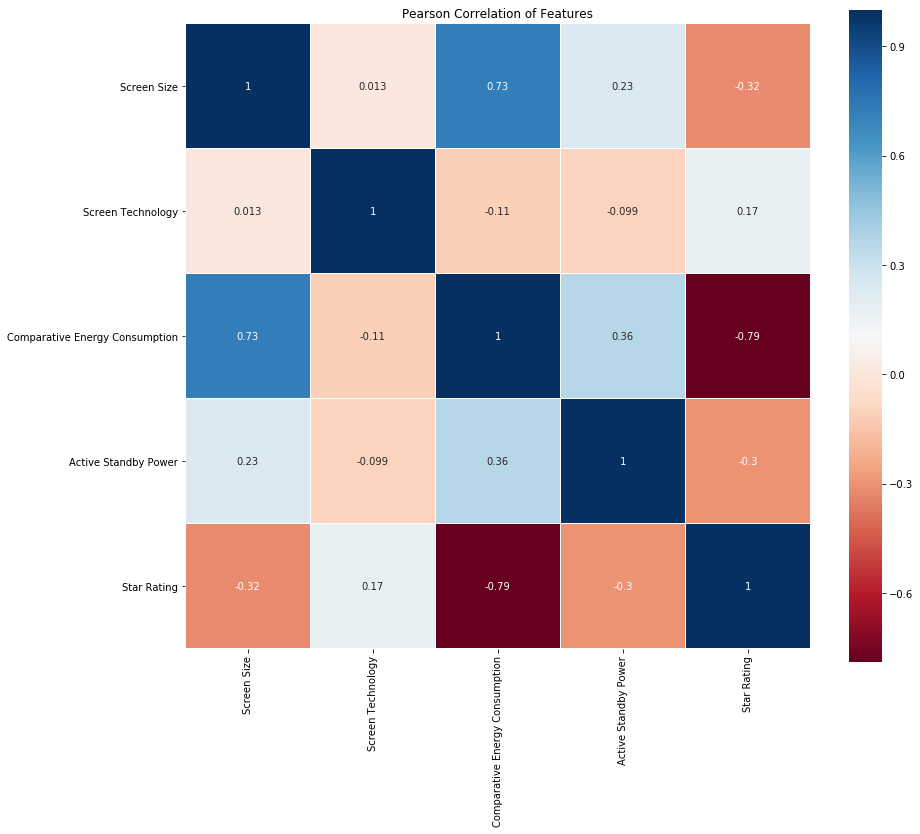

In [13]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, annot=True)

In [14]:
# As we can see, there is a high correlation between Comparitive Energy Consumption and Screen Size, 
# we can drop Screen since it is redundant to include it in the training model, and its not important in the
# prediction model
data.drop(['Screen Size'], axis=1, inplace=True)
data.head(3)

,Screen Technology,Comparative Energy Consumption,Active Standby Power,Star Rating
0,0,5,0,1
1,0,5,0,1
2,0,5,0,1


In [15]:
train_x = data.drop('Star Rating', axis=1)
train_y = data['Star Rating']
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1)

train_x

,Screen Technology,Comparative Energy Consumption,Active Standby Power
142,1,7,2
736,0,10,5
599,0,4,2
632,0,2,1
404,0,6,3
1494,0,8,1
1013,0,10,5
198,0,6,0
159,1,0,1
227,0,10,5


In [16]:
# After running a few Classification models the Random Forest Classifier gave the best accuracy
# We can fine tune the hyper-parameters to achieve a better score

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', oob_score=True)
random_forest.fit(train_x, train_y)

random_forest_predictions = random_forest.predict(train_x)

random_forest_accuracy = round(random_forest.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,random_forest_accuracy)

print("Precision score: ", precision_score(train_y, random_forest_predictions, average=None))
print("Recall score: ", recall_score(train_y, random_forest_predictions, average=None))
print("F Score: ", f1_score(train_y, random_forest_predictions, average=None))

Accuracy:  79.7
Precision score:  [0.81542056 0.77946128 0.80737705]
Recall score:  [0.84503632 0.79553265 0.72693727]
F Score:  [0.82996433 0.78741497 0.76504854]


In [17]:
random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', oob_score=True)
random_forest.fit(test_x, test_y)

random_forest_predictions = random_forest.predict(test_x)

random_forest_accuracy = round(random_forest.score(test_x, test_y) * 100, 2)
print("Accuracy: " ,random_forest_accuracy)

print("Precision score: ", precision_score(test_y, random_forest_predictions, average=None))
print("Recall score: ", recall_score(test_y, random_forest_predictions, average=None))
print("F Score: ", f1_score(test_y, random_forest_predictions, average=None))

Accuracy:  83.91
Precision score:  [0.8699187  0.82142857 0.81481481]
Recall score:  [0.87704918 0.82142857 0.8       ]
F Score:  [0.87346939 0.82142857 0.80733945]


In [18]:
# TODO: Fine tuning and testing boundary cases